# DIC Phase 2
## Prof. Eric Mikida
### Yashika Nihalani, 50425015
### Ashutosh Shailesh Bhawsar, 50416025

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

import time

import matplotlib
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import activation

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
btc_main = pd.read_csv('/content/drive/MyDrive/DIC Project/bitcoin_daily_data_cleaned.csv', index_col='Timestamp')

btc_data = btc_main[['Weighted_Price']]
btc_data['Weighted_Price'].fillna(method='ffill', inplace=True)
btc_data

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,Weighted_Price
Timestamp,
2011-12-31,4.47
2012-01-01,4.81
2012-01-02,5.00
2012-01-03,5.25
2012-01-04,5.21
...,...
2021-03-27,55193.36
2021-03-28,55832.96
2021-03-29,56913.99


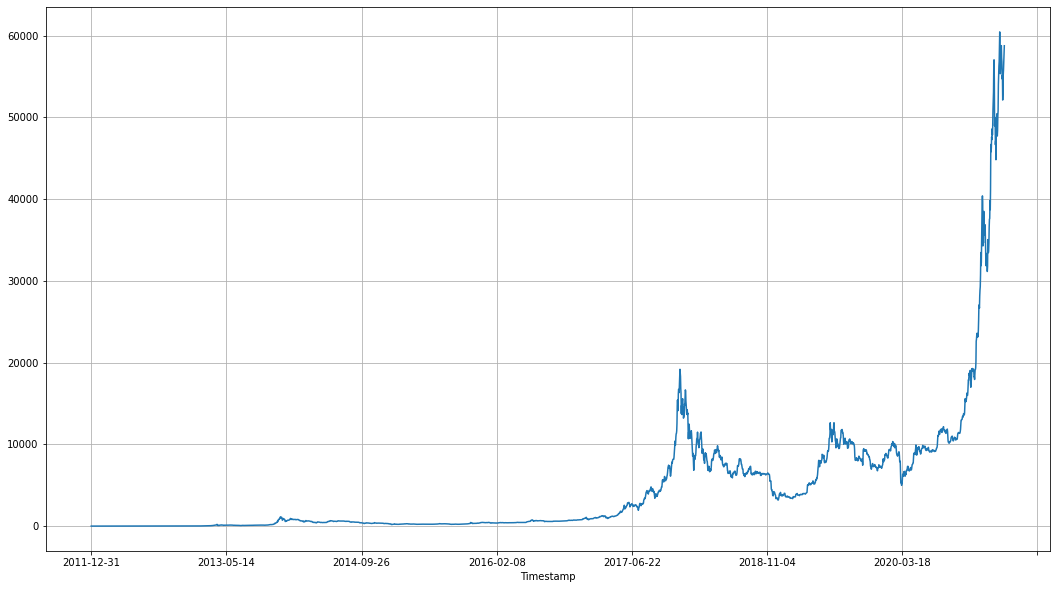

In [4]:
btc_data['Weighted_Price'].plot(figsize = (18, 10), grid = True)

# **Algorithms and their Visualizations**

##### **1) Linear Regression**

##### **2) KNN Classifier**

##### **3) Random Forest Regressor**

##### **4) Long Short Term Memory (LSTM)**

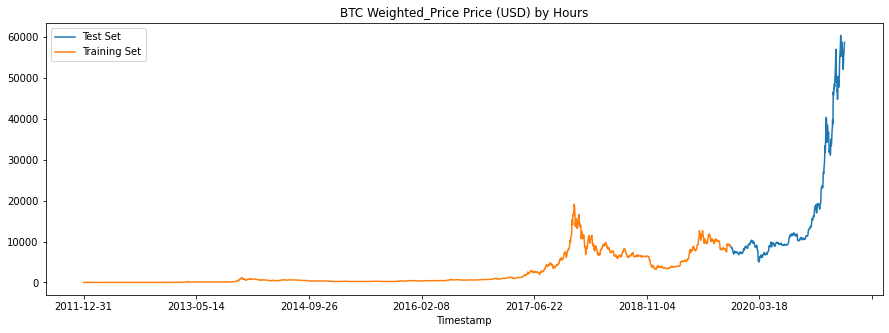

In [5]:
# Splitting the dataset

splitting_index = int(0.85*len(btc_data))
df_train = btc_data.iloc[:splitting_index,:]
df_test = btc_data.iloc[splitting_index:,:]

_ = df_test.rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(df_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

In [6]:
training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [7]:

# Initialising the RNN
regressor = Sequential()

# Adding the input layer and the LSTM layer
regressor.add(LSTM(units = 128, activation = 'sigmoid', input_shape = (1, 1)))

regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.summary()

# Fitting the RNN to the Training set
model_history = regressor.fit(X_train, y_train, batch_size = 50, epochs = 100, verbose = 2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
58/58 - 5s - loss: 0.0691 - 5s/epoch - 94ms/step
Epoch 2/100
58/58 - 1s - loss: 0.0570 - 572ms/epoch - 10ms/step
Epoch 3/100
58/58 - 1s - loss: 0.0484 - 636ms/epoch - 11ms/step
Epoch 4/100
58/58 - 1s - loss: 0.0418 - 613ms/epoch - 11ms/step
Epoch 5/100
58/58 - 1s - loss: 0.0350 - 607ms/epoch - 10ms/step

16/16 [==============================] - 0s 2ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


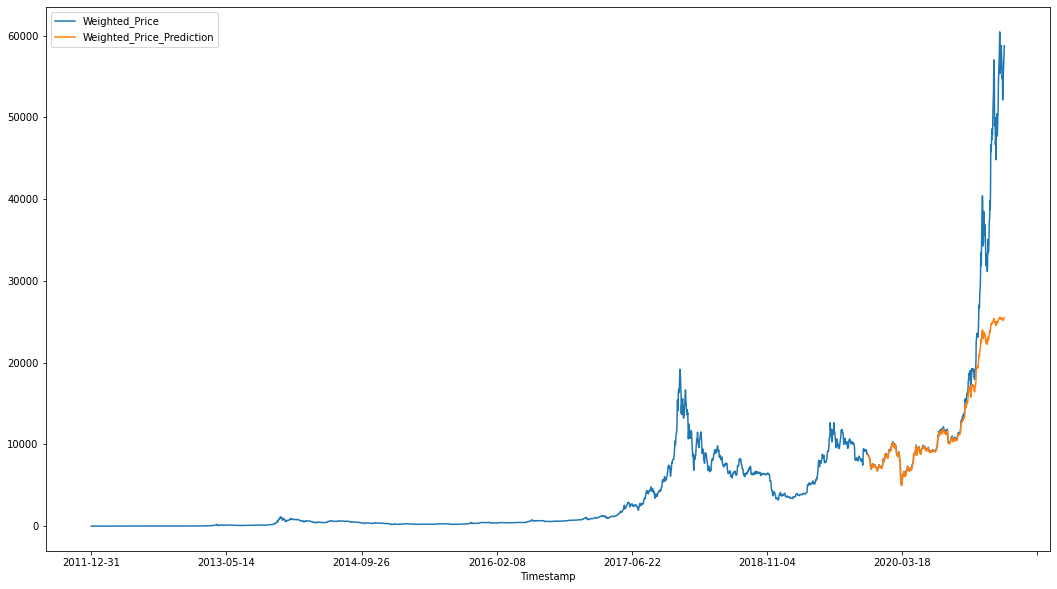

In [8]:
# Making the predictions
test_set = df_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = regressor.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)
df_test['Weighted_Price_Prediction'] = predicted_BTC_price
data_all = pd.concat([df_train, df_test], sort=False)
_ = data_all[['Weighted_Price','Weighted_Price_Prediction']].plot(figsize=(18, 10))

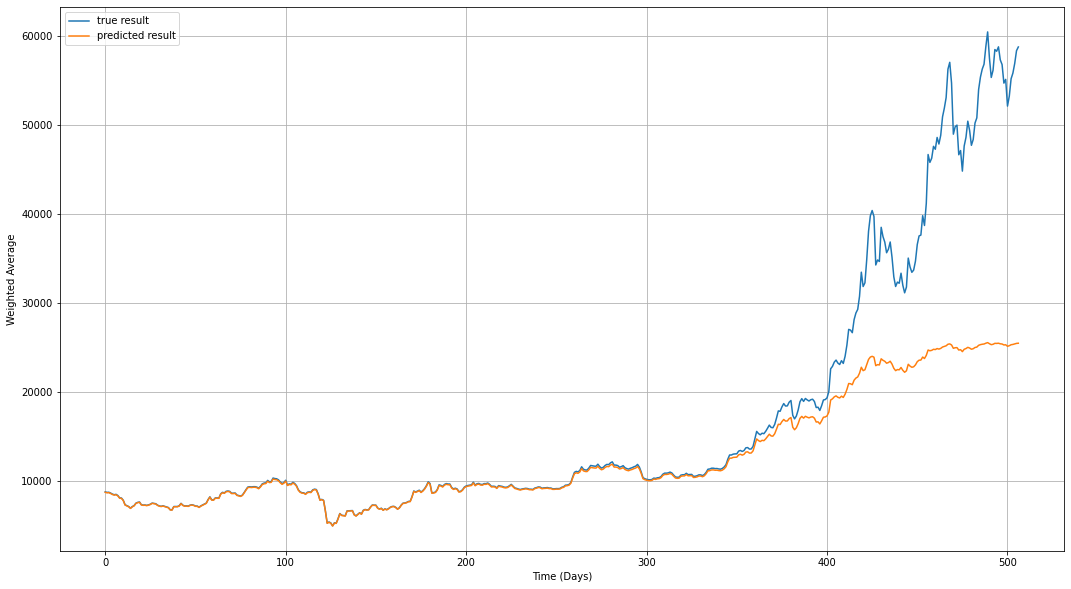

In [9]:
# Visualising the results

plt.figure(figsize=(18,10))
plt.plot(test_set, label="true result")
plt.plot(predicted_BTC_price, label="predicted result")
plt.legend()
plt.xlabel("Time (Days)")
plt.ylabel("Weighted Average")
plt.grid(True)
plt.show()

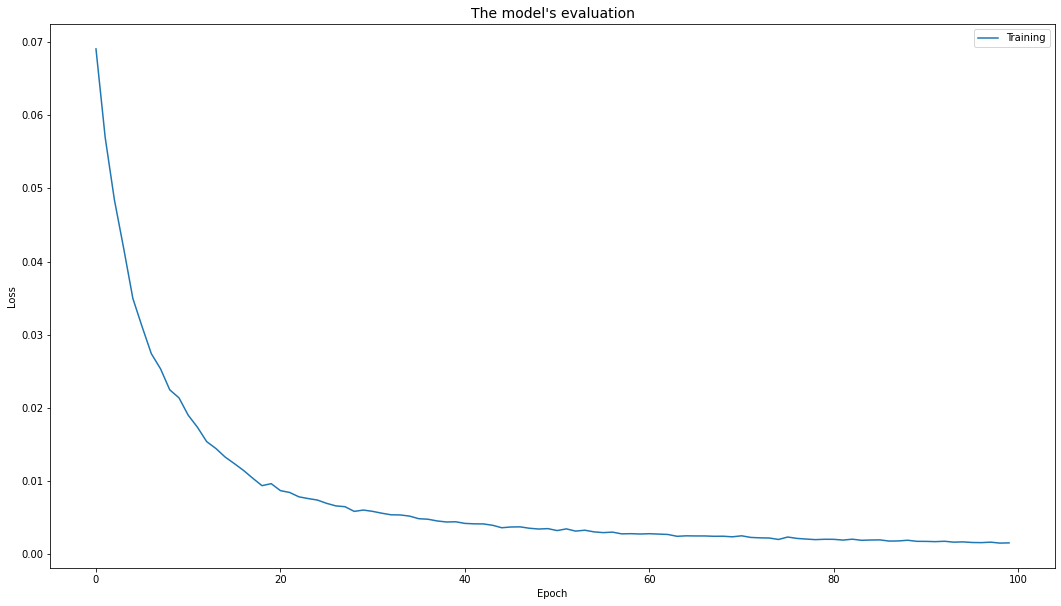

In [10]:
plt.figure(figsize=(18,10))
plt.plot(model_history.history['loss'])
plt.legend(['Training'])
plt.title("The model's evaluation", fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

##### **5) Prophet**

In [11]:
weighted_data=pd.DataFrame({})
weighted_data.index=btc_main.index
weighted_data['Weighted_Price']=btc_main['Weighted_Price']
weighted_data['Weighted_Price'].fillna(method='ffill', inplace=True)
weighted_data

,Weighted_Price
Timestamp,
2011-12-31,4.47
2012-01-01,4.81
2012-01-02,5.00
2012-01-03,5.25
2012-01-04,5.21
...,...
2021-03-27,55193.36
2021-03-28,55832.96
2021-03-29,56913.99


In [12]:
splitting_index = int(0.85*len(btc_data))
df_train = weighted_data.iloc[:splitting_index,:]
df_test = weighted_data.iloc[splitting_index:,:]
df_train=df_train.dropna()
df_test=df_test.dropna()
print(df_train.shape)
print(df_test.shape)

(2872, 1)
(507, 1)
